<a href="https://colab.research.google.com/github/kaycelin/Github-Colab-Codex-test/blob/main/Test%5Cbeamformer_TimeDelay_2p3GHz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

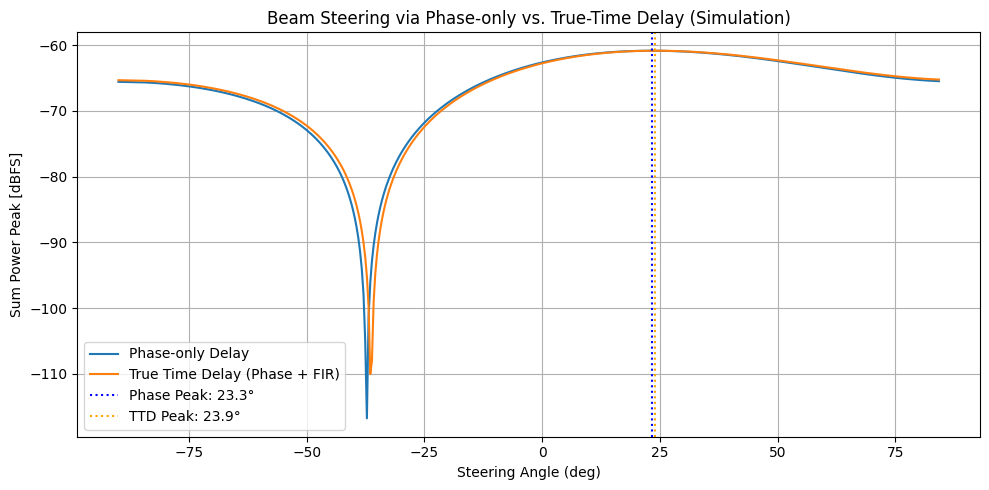

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 模擬參數
samp_rate = 30e6  # 取樣率 [Hz]
NumSamples = 2**12
f_carrier = 2.3e9  # 載波頻率
fc0 = 200e3        # 基頻 tone 頻率
c = 3e8
wavelength = c / f_carrier
d = 0.5 * wavelength  # 天線間距 = λ/2
time_max = d / c * 1e12  # 最大延遲 [ps]
time_cal = -80  # 校正 [ps]
delay_times = np.arange(-time_max, time_max, time_max/200)

# 建立模擬訊號：正弦 tone
ts = 1 / samp_rate
t = np.arange(NumSamples) * ts
signal = np.exp(1j * 2 * np.pi * fc0 * t)

# 人工加上 20° 的入射角所對應的理論延遲
theta_target = 20  # deg
true_delay_ps = d * np.sin(np.deg2rad(theta_target)) / c * 1e12

# Rx0 = 原始訊號；Rx1 = 延遲版（目標方向）
def time_delayer(data, delay_time_ps, freq, samp_rate, do_phase_delay=True, do_time_delay=False):
    delayed_data = data
    if do_phase_delay:
        delayed_data = delayed_data * np.exp(1j * 2 * np.pi * freq * delay_time_ps * 1e-12)
    if do_time_delay:
        delay = samp_rate * delay_time_ps * 1e-12
        N = 21
        n = np.arange(-N//2, N//2)
        h = np.sinc(n - delay)
        h *= np.hamming(N)
        h /= np.sum(h)
        delayed_data = np.convolve(delayed_data, h, mode='same')
    return delayed_data

Rx_0 = signal
Rx_1 = time_delayer(signal, true_delay_ps + time_cal, f_carrier, samp_rate)

# 計算 FFT dBFS
def dbfs(raw_data):
    win = np.hamming(len(raw_data))
    s_fft = np.fft.fft(raw_data * win) / np.sum(win)
    s_shift = np.fft.fftshift(s_fft)
    s_dbfs = 20 * np.log10(np.abs(s_shift) / (2**11))
    return s_dbfs

# 掃描不同延遲（模擬波束掃描）
peak_sum = []
peak_sum_time = []
for time_delay in delay_times:
    # Phase-only
    delayed_Rx1 = time_delayer(Rx_1, time_delay + time_cal, f_carrier, samp_rate, do_phase_delay=True, do_time_delay=False)
    summed = Rx_0 + delayed_Rx1
    summed_dbfs = dbfs(summed)
    peak_sum.append(np.max(summed_dbfs))

    # Phase + true time
    delayed_Rx1_time = time_delayer(Rx_1, time_delay + time_cal, f_carrier, samp_rate, do_phase_delay=True, do_time_delay=True)
    summed_time = Rx_0 + delayed_Rx1_time
    summed_time_dbfs = dbfs(summed_time)
    peak_sum_time.append(np.max(summed_time_dbfs))

# 轉換延遲為角度
def calcTheta(delay_ps):
    arcsin_arg = delay_ps * 1e-12 * c / d
    arcsin_arg = np.clip(arcsin_arg, -1, 1)
    return np.rad2deg(np.arcsin(arcsin_arg))

steer_angles = np.array([calcTheta(t) for t in delay_times])
peak_idx_phase = np.argmax(peak_sum)
peak_idx_time = np.argmax(peak_sum_time)

# 繪圖
plt.figure(figsize=(10, 5))
plt.plot(steer_angles, peak_sum, label='Phase-only Delay')
plt.plot(steer_angles, peak_sum_time, label='True Time Delay (Phase + FIR)')
plt.axvline(steer_angles[peak_idx_phase], color='blue', linestyle=':', label=f'Phase Peak: {steer_angles[peak_idx_phase]:.1f}°')
plt.axvline(steer_angles[peak_idx_time], color='orange', linestyle=':', label=f'TTD Peak: {steer_angles[peak_idx_time]:.1f}°')
plt.title("Beam Steering via Phase-only vs. True-Time Delay (Simulation)")
plt.xlabel("Steering Angle (deg)")
plt.ylabel("Sum Power Peak [dBFS]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
